### Import the required Libraries

* numpy : matrices  
* matplotlib : graphs
* tensorflow : to create machine learning models 
* OpenCV : allows you to perform image processing and computer vision tasks







In [1]:
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Dropout,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

## Data collection 

In [14]:
#roi - region of interest
top=60
b0ottom=310
right=60
left=260
    
    
background=None
count = 0

digit=0

sample_number=0

In [3]:
def segmentation(frame,thresshold=30):
    global background
    
    difference = cv2.absdiff(background.astype("uint8"), frame)
    _,processed_frame=cv2.threshold(difference,thresshold,255,cv2.THRESH_BINARY)
    contours,_=cv2.findContours(processed_frame,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
        contour = max(contours,key = cv2.contourArea)
    return (processed_frame,contour)

    

In [ ]:
cam = cv2.VideoCapture(0)

#roi - region of interest
top=50
bottom=300
right=50
left=250
    
    
background=None
count = 0

digit=0

sample_number=0
while True: 
    value , frame = cam.read()
    framecopy=frame.copy()
    framecopy=cv2.flip(framecopy,1)
    roi = framecopy[top:bottom,right:left]
    roi_gray=cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
    roi_gray=cv2.GaussianBlur(roi_gray,(9,9),0)
    
    if background is None:
        background = roi_gray.copy().astype('float')
    
    
    
    cv2.rectangle(framecopy,(left,top),(right,bottom),(0,0,255),3)
    if count < 30:
        cv2.accumulateWeighted(roi_gray,background,0.5)
        cv2.putText(framecopy,'Loading...',(280,200),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)

    collection = segmentation(roi_gray)
    k = cv2.waitKey(1)

    if collection is not None:
        roi_processed,contour=collection
        cv2.drawContours(framecopy,[contour+(right,top)],-1,(0,255,0),3)
        
        if k == ord(" "):
            cv2.putText(framecopy,str(sample_number)+' Gesture('+str(digit)+' )',(70,45),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)
            cv2.imwrite('D:/signs/'+str(digit)+'/'+str(digit)+'-'+str(sample_number)+'.jpg',roi_processed)
            sample_number+=1
            
        cv2.imshow('Segmantation',roi_processed)
        
    cv2.putText(framecopy,'Gesture( '+str(digit)+' )',(50,340),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),1)

    cv2.imshow('Camera',framecopy)

    count+=1
    if k == 27:
        break
    elif k == 13:
        digit = (digit+1) % 26
        sample_number=0
        
        
    
cv2.destroyAllWindows()
cam.release()

## Load our dataset (train)

In [4]:
train_data_path="D:/signs"
train_data_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_data_path, target_size=(64,64), class_mode='categorical', batch_size=26, shuffle=True)


Found 21060 images belonging to 26 classes.


In [5]:
images_train , labels_train = next(train_data_batches)

## Load our dataset (test)

In [6]:
test_data_path = "D:/test3"
test_data_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_data_path, target_size=(64,64), class_mode='categorical', batch_size=26, shuffle=True)


Found 5147 images belonging to 26 classes.


In [7]:
images_test , labels_test = next(test_data_batches)

## Let's see how our dataset actually looks like.

In [8]:
def display(images):
    fig,axes = plt.subplots(1,26,figsize=(30,20))
    for image ,ax in zip(images,axes):
        image=np.clip(image,0,1)
        ax.imshow(image)
        ax.axis('off')
        
    plt.tight_layout
    plt.show()

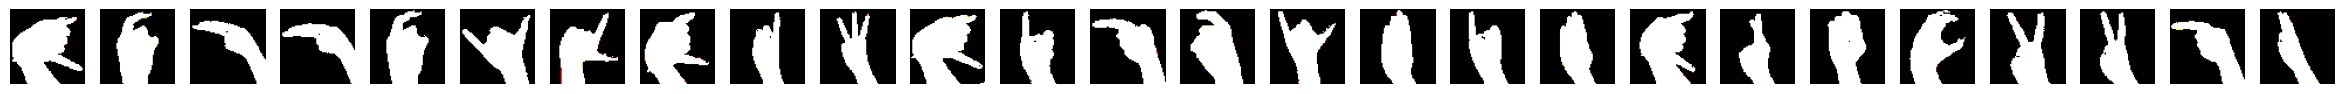

In [9]:
display(images_train)

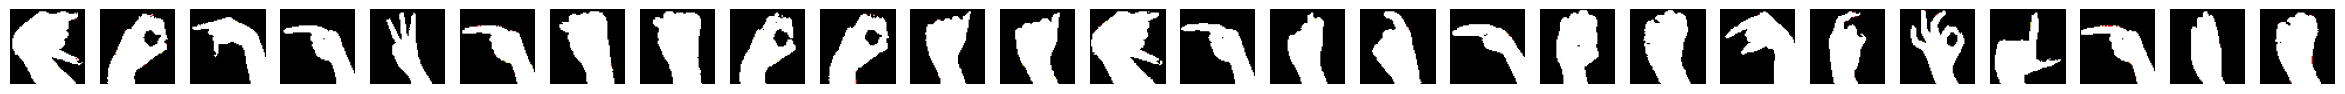

Z G H W P W E E G G A A Z W L S X U K I Q V D W B K 

In [10]:
words = {}

for i in range(26):
    words[i] = chr(i + 65)

display(images_test)

def digits(labels):
    for label in labels:
        print(words[np.argmax(label)],end=" ")
        
digits(labels_test)

## Building our model using CNN

In [ ]:
def createModel():
    model = Sequential()
    
    model.add(Conv2D(filters=32,kernel_size=(3,3), activation='relu',input_shape=(64,64,3)))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    
    model.add(Conv2D(filters=64,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
        
    model.add(Conv2D(filters=128,kernel_size=(3,3), activation='relu',padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    
    model.add(Flatten())
    
    model.add(Dense(64,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(26,activation='softmax'))
    
    return model

model=createModel()


    


    

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

## Compiling the model
compilation is the final step in creating a model.Once the compilation is done, we can move on to training phase.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=1,min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss',min_delta=0,patience=1,mode='auto',verbose=0)

In [ ]:
model.fit(train_data_batches,epochs=10,callbacks=[reduceLR,early_stop],validation_data=test_data_batches)

Epoch 1/10
810/810 [==============================] - 63s 76ms/step - loss: 0.6375 - accuracy: 0.8246 - val_loss: 0.1692 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 2/10
810/810 [==============================] - 60s 75ms/step - loss: 0.0569 - accuracy: 0.9841 - val_loss: 0.1450 - val_accuracy: 0.9646 - lr: 0.0010
Epoch 3/10
810/810 [==============================] - 61s 75ms/step - loss: 0.0545 - accuracy: 0.9864 - val_loss: 0.2136 - val_accuracy: 0.9479 - lr: 0.0010


In [ ]:
score = model.evaluate(images_test,labels_test,verbose=0)
print(f'{model.metrics_names[0]} = {score[0]} || {model.metrics_names[1]} = {score[1]*100}%')

loss = 0.1345614790916443 || accuracy = 96.15384340286255%


## Saving the model.

In [ ]:
model.save('D:\SignLanguageFinal.h5')


In [11]:
model4 = tf.keras.models.load_model('D:\SignLanguageFinal.h5')

# test by camera

In [34]:
cam = cv2.VideoCapture(0)
#roi - region of interest
top=50
bottom=300
right=50
left=250
    
    
background=None
count = 0

digit=0

sample_number=0
while True: 
    value , frame = cam.read()
    framecopy=frame.copy()
    framecopy=cv2.flip(framecopy,1)
    roi = framecopy[top:bottom,right:left]
    roi_gray=cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
    roi_gray=cv2.GaussianBlur(roi_gray,(9,9),0)
    
    if background is None:
        background = roi_gray.copy().astype('float')
    
    
    
    cv2.rectangle(framecopy,(left,top),(right,bottom),(0,0,255),3)
    if count < 30:
        cv2.accumulateWeighted(roi_gray,background,0.5)
        cv2.putText(framecopy,'Loading...',(280,200),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)

    collection = segmentation(roi_gray)
    k = cv2.waitKey(1)

    if collection is not None:
        roi_processed,contour=collection
        cv2.drawContours(framecopy,[contour+(right,top)],-1,(0,255,0),3)
        
        roi_processed = cv2.resize(roi_processed,(64,64))
        roi_processed = cv2.cvtColor(roi_processed,cv2.COLOR_GRAY2RGB)
        frame = np.reshape(roi_processed,(1,roi_processed.shape[0],roi_processed.shape[1],3))
        
        value = model4.predict(frame)
        label = words[np.argmax(value)]
        cv2.putText(framecopy,str(label),(370,145),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)
        if k == ord(" "):
            cv2.putText(framecopy,str(sample_number)+' Gesture('+str(digit)+' )',(70,45),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)
            cv2.imwrite('D:/signs'+str(digit)+'/'+str(digit)+'-'+str(sample_number)+'.jpg',roi_processed)
            sample_number+=1
            
        cv2.imshow('Segmantation',roi_processed)
        
    cv2.putText(framecopy,'Gesture( '+str(digit)+' )',(50,340),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),1)

    cv2.imshow('Camera',framecopy)

    count+=1
    if k == 27:
        break
    elif k == 13:
        digit = (digit+1) % 26
        sample_number=0
        
        
    
cv2.destroyAllWindows()
cam.release()

1/1 [==============================] - 0s 23ms/step


# show Result


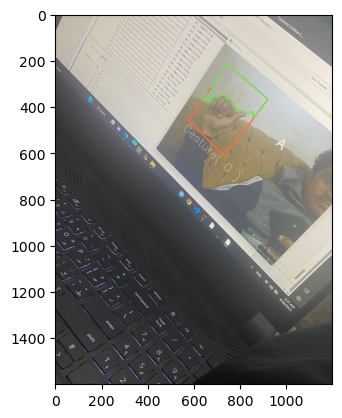

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open("D:/project IEEE/a.jpg")

plt.imshow(image)
plt.show()


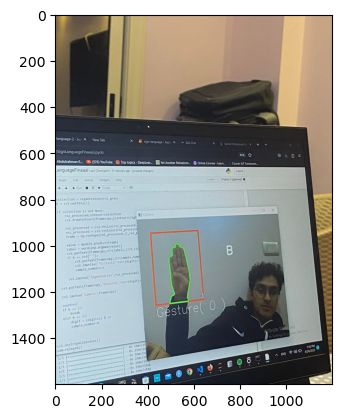

In [13]:

image = Image.open("D:/project IEEE/b.jpg")

plt.imshow(image)
plt.show()


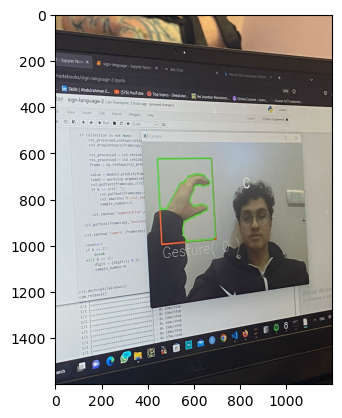

In [14]:

image = Image.open("D:/project IEEE/c.jpg")

plt.imshow(image)
plt.show()


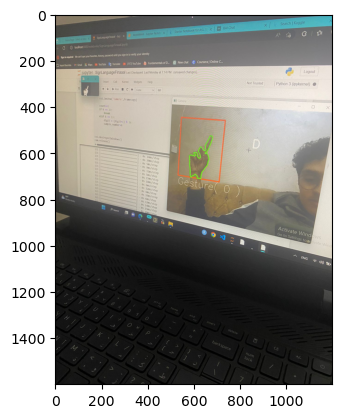

In [15]:

image = Image.open("D:/project IEEE/d.jpg")

plt.imshow(image)
plt.show()


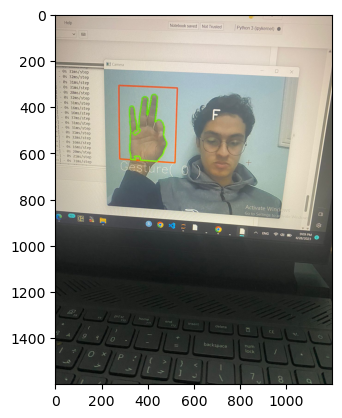

In [16]:

image = Image.open("D:/project IEEE/f.jpg")

plt.imshow(image)
plt.show()


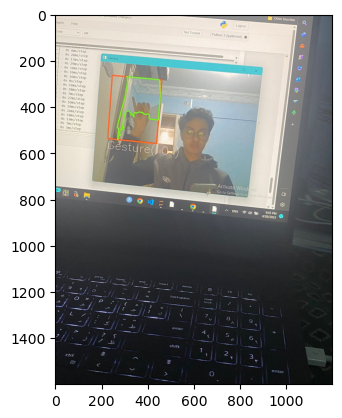

In [17]:

image = Image.open("D:/project IEEE/i.jpg")

plt.imshow(image)
plt.show()


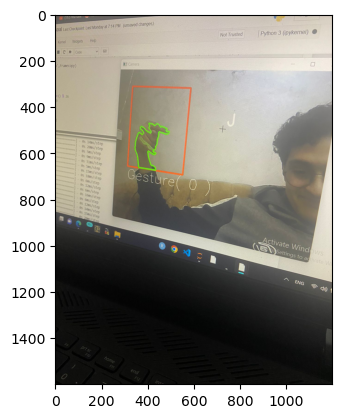

In [18]:

image = Image.open("D:/project IEEE/j.jpg")

plt.imshow(image)
plt.show()


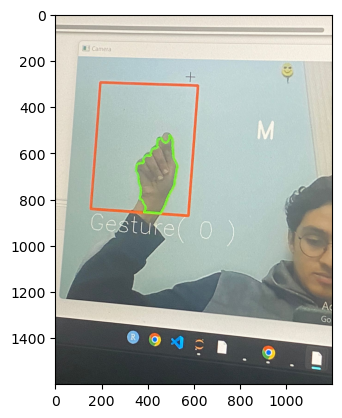

In [19]:

image = Image.open("D:/project IEEE/m.jpg")

plt.imshow(image)
plt.show()


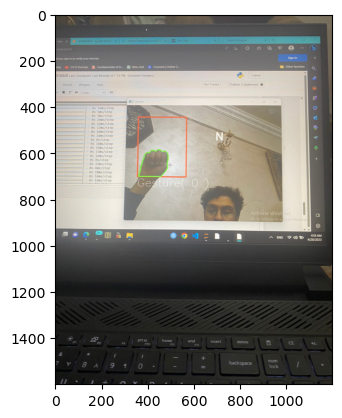

In [28]:

image = Image.open("D:/project IEEE/n.jpg")

plt.imshow(image)
plt.show()


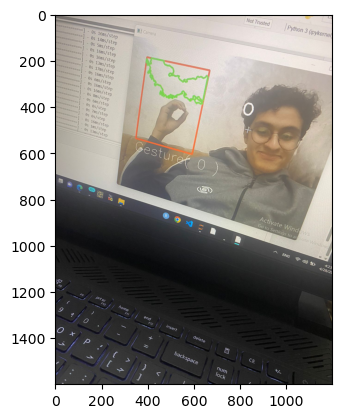

In [21]:

image = Image.open("D:/project IEEE/o.jpg")

plt.imshow(image)
plt.show()


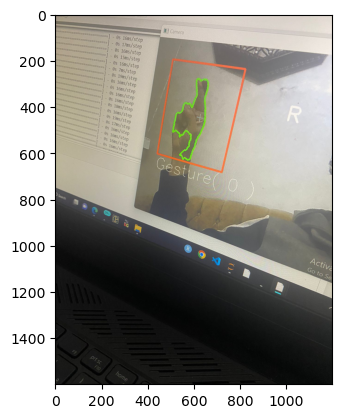

In [22]:

image = Image.open("D:/project IEEE/r.jpg")

plt.imshow(image)
plt.show()


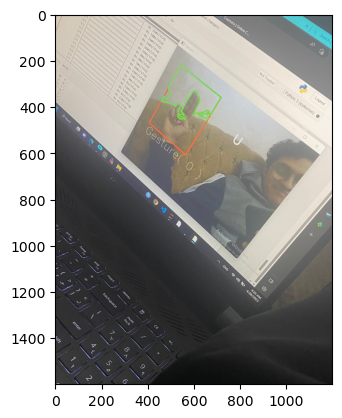

In [23]:

image = Image.open("D:/project IEEE/u.jpg")

plt.imshow(image)
plt.show()


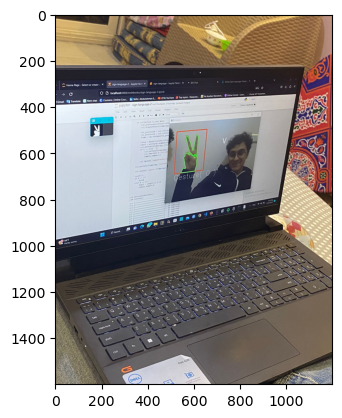

In [24]:

image = Image.open("D:/project IEEE/v.jpg")

plt.imshow(image)
plt.show()


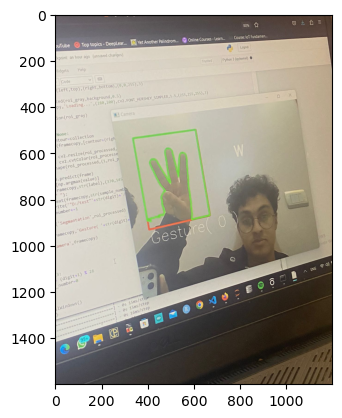

In [25]:

image = Image.open("D:/project IEEE/w.jpg")

plt.imshow(image)
plt.show()


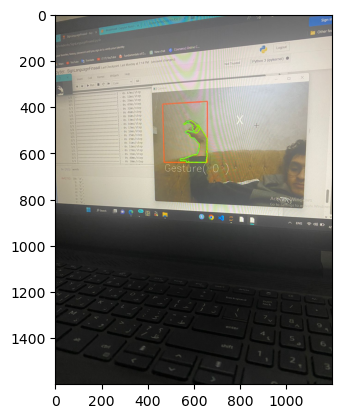

In [26]:

image = Image.open("D:/project IEEE/x.jpg")

plt.imshow(image)
plt.show()


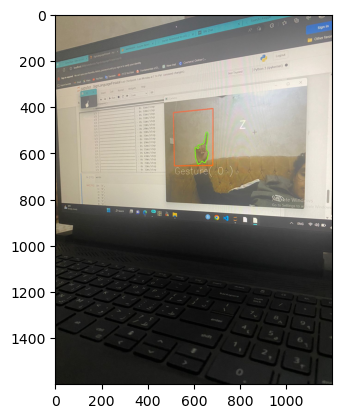

In [27]:

image = Image.open("D:/project IEEE/z.jpg")

plt.imshow(image)
plt.show()
